# Best Cities for University Students

#### Introduction to Business Problem
-----

This notebook is going to study and analyse the cities that are ranked best for university students. For many students and agencies, it is quiet troublesome to analyse which city is best for them to pursue a mayor not only on the degrees offered by the university's programs, but to the livestyle the university students want to have around them. Therefore, it is of mayor interest to cluster the best university cities around the globe in order to provide an overview and a list of similar options to students and agencies.  

Using the list of cities created by the __QS World University Rankings__, which can be found at [QS Best Student Cities](https://www.topuniversities.com/city-rankings/2019), we are going to observe similar cities based on the kind of businesses and venues they have around __10km__ from their _central business district_. This area of each city gives similar chances to see what kind of venues are agglomerated within the business center which can be helpful to most students that want to work and live in the same city they study their degree.

On another note, the QS rankings were derived from scores on in eight out of 12 categories. Four categories are mandatory, while institutions must choose the remaining four optional categories:
- Teaching
- Employability
- Research
- Internationalization
- Facilities
- Online/Distance Learning
- Arts & Culture
- Innovation
- Inclusiveness
- Social Responsibility
- Subject Ranking
- Program Strength

### Data for Business Problem
-----

In [4]:
# Installing necessary packages for webscraping and creation of map visualizations
!conda install beautifulsoup4
!conda install lxml
!conda install html5lib
!conda install requests
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         132 KB
    beautifulsoup4-4.8.2       |           py36_0         161 KB
    ------------------------------------------------------------
                                           Total:         294 KB

The following packages will be UPDATED:

    beautifulsoup4:  4.7.1-py36_1 --> 4.8.2-py36_0
    ca-certificates: 2019.11.27-0 --> 2020.1.1-0  


ca-certificates-2020 | 132 KB    | ##################################### | 100% 
beautifulsoup4-4.8.2 | 161 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environme

In [64]:
# Loading necessary packages for data manipulation and webscraping
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import json # library to handle JSON files

import geopy.geocoders
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [80]:
# The code was removed by Watson Studio for sharing.

,rank,city,country,address,lat,lon
0,1,London,United Kingdom,"London, United Kingdom",51.507322,-0.127647
1,2,Tokyo,Japan,"Tokyo, Japan",35.682839,139.759455
2,3,Melbourne,Australia,"Melbourne, Australia",-37.814218,144.963161
3,4,Munich,Germany,"Munich, Germany",48.137108,11.575382
4,5,Berlin,Germany,"Berlin, Germany",52.517037,13.388860
5,6,Montreal,Canada,"Montreal, Canada",45.497216,-73.610364
6,7,Paris,France,"Paris, France",48.856697,2.351462
7,8,Zurich,Switzerland,"Zurich, Switzerland",47.372394,8.542333
8,9,Sydney,Australia,"Sydney, Australia",-33.854816,151.216454
9,10,Hong Kong,Hong Kong,"Hong Kong, Hong Kong",22.279328,114.162813


__Foursquare Credentials and Version__

In [82]:
CLIENT_ID = 'DRF0SKJCMYWGQ5X0OO1KZJGFQL0BSF4WS53CUU53RJAVMMSD'
CLIENT_SECRET = 'DRGDZ0HCIGEG1CGWG3D1FYDREMR10XO3NF50FXYSOSNLU5BF'
VERSION = '20180605'

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function define above to collect the venue data for only the _10km_ within each __City__:

In [84]:
LIMIT = 2500 # limit of number of venues returned by Foursquare API

radius = 10000 # define radius

cities_venues = getNearbyVenues(names=qs_ranking['city'],
                                   latitudes=qs_ranking['lat'],
                                   longitudes=qs_ranking['lon']
                                  )

London
Tokyo
Melbourne
Munich
Berlin
Montreal
Paris
Zurich
Sydney
Hong Kong
Seoul
Toronto
Boston
Vienna
Edinburgh
Vancouver
Taipei
Kyoto
New York
Singapore
Barcelona
Brisbane
Canberra
Amsterdam
Los Angeles
Adelaide
Auckland
Madrid
Kuala Lumpur
Manchester
Buenos Aires
Beijing
Shanghai
Moscow
Prague
San Francisco
Dublin
Stockholm
Glasgow
Milan
Chicago
Perth
Brussels
Budapest
Ottawa
Copenhagen
Coventry
Nottingham
Birmingham
Lyon
Warsaw
Lisbon
Mexico
Santiago
Gothenburg
Helsinki
Atlanta
Newcastle Upon Tyne
Bangkok
Brno
Dubai
Philadelphia
Washington
Aberdeen
Christchurch
Saint Petersburg
Pittsburgh
Hsinchu
Stuttgart
Rome
Istanbul
Athens
Tomsk
Toulouse
Valencia
San Diego
Sao Paulo
Johannesburg
Graz
Cape Town
Bangalore
Bogota
Brighton
Gold Coast
Manila
Mumbai
Baltimore
Abu Dhabi
Ankara
Daejeon
Monterrey
Novosibirsk
Houston
Miami
Nagoya
Vilnius
Bristol
Lima
Nanjing
Montpellier
Beirut
Rio De Janeiro
Sheffield
Krakow
Wuhan
Liverpool
Cairo
Wroclaw
Jakarta
Riga
Islamabad
Almaty
Delhi
Dallas
Chenna

Encode each __City__ with its information on venues for clustering:

In [85]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = cities_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group the rows by __City__ and by taking the mean of frequency of each category of venue:

In [86]:
cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Aberdeen,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.010000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
1,Abu Dhabi,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.000000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
2,Adelaide,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.010000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.010000,0.00
3,Almaty,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.010000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
4,Amsterdam,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,0.00,0.01,0.00,0.00,0.03,0.00,0.00,0.00,0.000000,0.00
5,Ankara,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.012821,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
6,Athens,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
7,Atlanta,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.040000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
8,Auckland,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
9,Baltimore,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.030000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00


Let's define a function in order to obtain the _top 10_ kind of venues of each __City__:

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [159]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head(120)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aberdeen,Bar,Hotel,Café,Beer Bar,Park,Supermarket,Coffee Shop,Pub,Seafood Restaurant,Grocery Store
1,Abu Dhabi,Café,Hotel,Coffee Shop,Middle Eastern Restaurant,Spa,Gym,Shopping Mall,Restaurant,Indian Restaurant,Ice Cream Shop
2,Adelaide,Coffee Shop,Café,Hotel,Pub,Asian Restaurant,Park,Australian Restaurant,Sushi Restaurant,Garden,Mexican Restaurant
3,Almaty,Coffee Shop,Hotel,Café,Park,Steakhouse,Gym / Fitness Center,Restaurant,Bar,Spa,Seafood Restaurant
4,Amsterdam,Hotel,Bar,Coffee Shop,French Restaurant,Theater,Breakfast Spot,Cocktail Bar,Café,Restaurant,Yoga Studio
5,Ankara,Farm,Breakfast Spot,Restaurant,Pool,Garden,Racetrack,Botanical Garden,Rest Area,Kebab Restaurant,Meyhane
6,Athens,Coffee Shop,Historic Site,Bar,Café,Boutique,Cocktail Bar,Wine Bar,Hotel,Theater,Bookstore
7,Atlanta,Trail,Park,Mexican Restaurant,American Restaurant,Brewery,Mediterranean Restaurant,Southern / Soul Food Restaurant,Ice Cream Shop,Beer Store,Bar
8,Auckland,Café,Park,Restaurant,Plaza,Bar,Coffee Shop,Hotel,Gym,Italian Restaurant,Dessert Shop
9,Baltimore,Coffee Shop,Seafood Restaurant,Bar,Hotel,Aquarium,Park,Italian Restaurant,Mediterranean Restaurant,American Restaurant,Burger Joint


## Clustering of Neighborhoods

Define how many diferent clusters of __Cities__ are best:

In [124]:
from sklearn import metrics 
from scipy.spatial.distance import cdist

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,30) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(init = "k-means++", n_clusters = k, n_init = 25, random_state=0).fit(cities_grouped_clustering) 
    kmeanModel.fit(cities_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(cities_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cities_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cities_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cities_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

Plotting results from the __Elbow Method__:

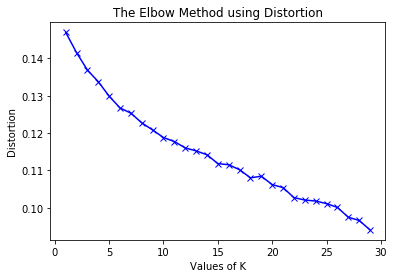

In [118]:
import matplotlib.pyplot as plt 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

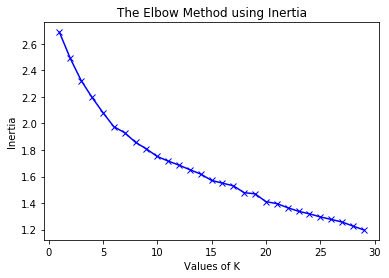

In [119]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

The __Elbow Method__ seems to suggest that __5 to 10__ clusters would be optimal. However, we are going to try the __Silhouette Score__ to have a better idea:

In [120]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(cities_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(cities_grouped_clustering, labels, metric = 'euclidean'))

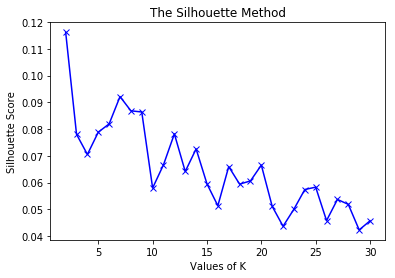

In [122]:
K = range(2,31)
plt.plot(K, sil, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Method') 
plt.show() 

#### Conclusion:

It appears that __7 clusters__ are optimal for the data on the _QS Ranking_ for _Best University Cities_ !!

In [160]:
# set number of clusters
kclusters = 7
non_clustered = kclusters

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init = 25, random_state=0).fit(cities_grouped_clustering)

# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = qs_ranking
cities_merged.rename(columns={'city':'City'}, inplace=True)

# merge cities_grouped with qs_ranking to add latitude/longitude for each city
cities_merged = cities_merged.join(cities_venues_sorted.set_index('City'), on='City')
cities_merged['Cluster Labels'].fillna(non_clustered, inplace = True)
cities_merged['Cluster Labels'] = cities_merged['Cluster Labels'].astype('Int64')

cities_merged.head(120) # check the last columns!

,rank,City,country,address,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,London,United Kingdom,"London, United Kingdom",51.507322,-0.127647,6,Hotel,Cocktail Bar,Theater,Art Museum,Bookstore,Clothing Store,Hotel Bar,Park,Steakhouse,Department Store
1,2,Tokyo,Japan,"Tokyo, Japan",35.682839,139.759455,4,Hotel,Chinese Restaurant,Wagashi Place,Art Museum,Ramen Restaurant,Sake Bar,Coffee Shop,Garden,Kaiseki Restaurant,Japanese Curry Restaurant
2,3,Melbourne,Australia,"Melbourne, Australia",-37.814218,144.963161,0,Café,Coffee Shop,Park,Cocktail Bar,Bar,Theater,Italian Restaurant,Plaza,Japanese Restaurant,Wine Bar
3,4,Munich,Germany,"Munich, Germany",48.137108,11.575382,0,Café,Hotel,Plaza,Cocktail Bar,German Restaurant,Ice Cream Shop,Church,Italian Restaurant,Coffee Shop,Art Museum
4,5,Berlin,Germany,"Berlin, Germany",52.517037,13.388860,3,Coffee Shop,Bookstore,Park,Concert Hall,Café,Ice Cream Shop,Hotel,Bakery,Monument / Landmark,Wine Bar
5,6,Montreal,Canada,"Montreal, Canada",45.497216,-73.610364,0,Café,Bakery,French Restaurant,Coffee Shop,Restaurant,Vegetarian / Vegan Restaurant,Portuguese Restaurant,Park,Salad Place,Lounge
6,7,Paris,France,"Paris, France",48.856697,2.351462,2,Plaza,Bookstore,Hotel,Cocktail Bar,French Restaurant,Wine Bar,Art Museum,Garden,Art Gallery,Bakery
7,8,Zurich,Switzerland,"Zurich, Switzerland",47.372394,8.542333,2,Bar,Swiss Restaurant,Plaza,Hotel,Café,Vegetarian / Vegan Restaurant,Bakery,Cocktail Bar,Restaurant,Lounge
8,9,Sydney,Australia,"Sydney, Australia",-33.854816,151.216454,0,Park,Café,Scenic Lookout,Theater,Bakery,Coffee Shop,Pub,Ice Cream Shop,Hotel,Thai Restaurant
9,10,Hong Kong,Hong Kong,"Hong Kong, Hong Kong",22.279328,114.162813,6,Hotel,Italian Restaurant,Japanese Restaurant,Coffee Shop,Gym / Fitness Center,Scenic Lookout,Steakhouse,Café,Bar,Yoga Studio


### Visualize the Clusters

In [161]:
# create map of Toronto using latitude and longitude values
world_map = folium.Map(location=[0, 0], zoom_start=2.8)

# set color scheme for the clusters
x = np.arange(non_clustered)
ys = [i + x + (i*x)**2 for i in range(non_clustered)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['lat'], cities_merged['lon'], cities_merged['City'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(world_map)
    
world_map

Let's analyse the clusters by __Rank__:

In [162]:
cities_merged_final = cities_merged
cities_merged_final_rank = cities_merged_final.groupby('Cluster Labels', sort = True).mean().reset_index()
cities_merged_final_rank.head()

,Cluster Labels,rank,lat,lon
0,0,55.086957,18.950627,53.821943
1,1,67.750000,53.100432,-2.271660
2,2,49.692308,44.745979,5.550709
3,3,63.925926,25.641169,35.364453
4,4,58.296296,31.280112,-39.010178


In [167]:
cities_merged_final_most_common = cities_merged_final[['Cluster Labels', '1st Most Common Venue']]
cities_merged_final_most_common.groupby(['Cluster Labels', '1st Most Common Venue']).size()

Cluster Labels  1st Most Common Venue  
0               Beer Bar                    1
                Café                       16
                Hotel                       1
                Indian Restaurant           1
                Pakistani Restaurant        1
                Park                        2
                Restaurant                  1
1               Bar                         1
                Coffee Shop                 2
                Pub                         9
2               Bar                         1
                French Restaurant           3
                Hotel                       4
                Italian Restaurant          1
                Plaza                       4
3               Bar                         1
                Café                        4
                Cocktail Bar                1
                Coffee Shop                17
                Hotel                       1
                Park                    

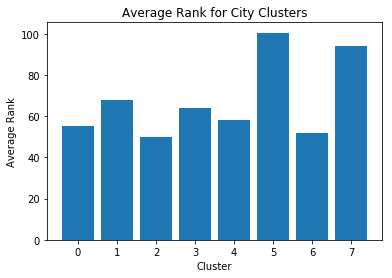

In [164]:
plt.bar(cities_merged_final_rank['Cluster Labels'], cities_merged_final_rank['rank']) 
plt.xlabel('Cluster') 
plt.ylabel('Average Rank') 
plt.title('Average Rank for City Clusters') 
plt.show() 

#### Insights

- Clusters 2 and 6 have the lowest average rank in the __QS Ranking__; this clusters correspond to Western European and Asian Cities.
- Cluster 2 has __Hotels and Plazas__ the most around their inner 10km radius.
- The most common venues in cities within cluster 6 are __Hotels__.
- Cluster 0 has cities from __South America, Eastern Europe and Oceania__, making it the most diverse group where __Cafés__ are the most common venues in their inner cities.
- Cluster 1 are mostly __British cities__ and unsurprinsingly the most common venues are __Pubs__.
- Cluster 3 have __Coffee Shops__ as their most common venues and are cities located from __Canada__ all the way across to __Australia__.